<a href="https://colab.research.google.com/github/EirafWali/Supervised_Wells_ML/blob/main/Supervised_Wells_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised ML: Well logs prediction

# Introduction

Having a full set of well logs is not always feasible for all companies. In many cases, well logs may be incomplete due to acquisition constraints or tool failures, which leads to missing logs or missing intervals. This makes the logs analysis challenging. To address this, this notebook uses machine learning techniques to predict missing well logs from other available data, improving reservoir characterization without the need for costly additional logging operations.
In this project, I focus on predicting Density Log (RHOB) using other available well logs such as Sonic Travel Time (DTC), Gamma Ray (GR), and Neutron Porosity (NPHI). This will be done by applying and comparing Linear Regression, K-Nearest Neighbors (KNN) Regression, and Decision Tree Regression to assess which model provides the most accurate predictions for the density log. Each model is evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) to ensure reliable performance.

Source: https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

About the dataset: This dataset contains well logs that were used in a competition in 2020 to predict the lithology.In this notebook, I will use the same dataset (logs) to try and predict the desnity log.


Importance:
- This work is useful when there are missing logs. Can be used in research or  in the oil and gas industry .

## Section 1: Loading, Cleaning, and EDA of the Dataset

In [1]:
!pip install requests lasio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.6 MB/s eta 0:00:00


In [2]:
# Import needed libraries
import os
import pandas as pd
import requests
import lasio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Read the Las files from Github repository

# GitHub repo details
repo_url = "https://api.github.com/repos/EirafWali/Supervised_Wells_ML/contents/las_files"
local_directory = "las_files"

# Create a local folder
os.makedirs(local_directory, exist_ok=True)

# Requests the files from github and checks if that was successful (200=success)
response = requests.get(repo_url)
if response.status_code != 200:
    raise Exception("Failed to fetch LAS files from GitHub")

# Only get the LAS files
las_file_urls = [file["download_url"] for file in response.json() if file["name"].endswith(".las")]

# Download and save the LAS files
for url in las_file_urls:
    filename = os.path.join(local_directory, os.path.basename(url))
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        with open(filename, 'wb') as f:
            f.write(requests.get(url).content)
    else:
        print(f"{filename} already exists.")

# Read and print LAS files and the number of curves
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
# Add a try-except block to handle potential errors
        try:
            las = lasio.read(os.path.join(local_directory, filename))
            print(f"Loaded {filename} with {len(las.curves)} curves.")
        except KeyError as e:
            print(f"Error reading {filename}: {e}")


Loaded 34_8-1.las with 21 curves.
Error reading 34_3-3%20A.las: 'No ~ sections found. Is this a LAS file?'
Loaded 25_6-1.las with 21 curves.
Loaded 35_11-6.las with 19 curves.
Loaded 35_11-15%20S.las with 23 curves.
Loaded 34_10-21.las with 19 curves.
Error reading 35_9-8.las: 'No ~ sections found. Is this a LAS file?'
Loaded 31_3-1.las with 19 curves.
Loaded 31_4-5.las with 21 curves.
Loaded 31_2-9.las with 20 curves.
Loaded 35_3-7%20S.las with 21 curves.
Loaded 16_10-2.las with 20 curves.
Loaded 31_5-4%20S.las with 18 curves.
Loaded 16_2-7.las with 22 curves.
Loaded 25_2-13%20T4.las with 21 curves.
Loaded 25_9-1.las with 23 curves.
Loaded 35_11-7.las with 19 curves.
Loaded 30_3-5%20S.las with 16 curves.
Loaded 31_6-5.las with 18 curves.
Error reading 7_1-1.las: 'No ~ sections found. Is this a LAS file?'
Loaded 25_7-2.las with 24 curves.
Loaded 34_3-1%20A.las with 21 curves.
Loaded 25_8-5%20S.las with 25 curves.
Loaded 34_10-16%20R.las with 19 curves.
Loaded 26_4-1.las with 22 curves.

Note that there were some errors in reading the data.
The next code deletes any problematic LAS files

In [4]:
# This code will remove the problematic las files from the dataset

local_directory = "las_files"

# Loop through all LAS files
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
        filepath = os.path.join(local_directory, filename)

        try:
            # Try reading the LAS file
            las = lasio.read(filepath)
        except Exception as e:
            # If there's an error, delete the file
            print(f"Deleting {filename} due to error: {e}")
            os.remove(filepath)

print("Clean-up complete. All problematic LAS files have been deleted.")


Deleting 34_3-3%20A.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-8.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 7_1-1.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_6-1%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-5.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-6%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_5-1%20A.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_5-1%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_7-13.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-10%20S.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-2.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 35_9-7.las due to error: 'No ~ sections found. Is this a LAS file?'
Deleting 34_4-10%20R.las due to error: 'No ~ sectio

After removing the problematic wells, let's count how many wells we have remaining:

In [5]:
# Count the number of LAS files in the directory
las_files = [file for file in os.listdir(local_directory) if file.endswith(".las")]
total_wells = len(las_files)

print(f"Total number of wells: {total_wells}")

Total number of wells: 104


In [6]:
# Create a dataframe with all the wells for easier coding and analysis

# dataframe to store individual wells
dfs = []

# Loop through each LAS file
for filename in os.listdir(local_directory):
    if filename.endswith(".las"):
        filepath = os.path.join(local_directory, filename)

        try:
            # Read the LAS file
            las = lasio.read(filepath)

            # Convert LAS data to a dataframe
            df = las.df()

            # Add a 'Well' column to keep track of which well the data came from
            df['Well'] = os.path.splitext(filename)[0]  # Use the filename as the well name

            # Append this well's data to the list
            dfs.append(df)

        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

# Combine all DataFrames into one and check if anything is still problematic
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    print(combined_df.head())
else:
    print("No valid wells were processed.")

Combined DataFrame shape: (2034847, 27)
   FORCE_2020_LITHOFACIES_CONFIDENCE  FORCE_2020_LITHOFACIES_LITHOLOGY  CALI  \
0                                NaN                               NaN   NaN   
1                                NaN                               NaN   NaN   
2                                NaN                               NaN   NaN   
3                                NaN                               NaN   NaN   
4                                NaN                               NaN   NaN   

   BS       RDEP  RSHA      RMED  RXO         SP  DTC  ...      X_LOC  \
0 NaN        NaN   NaN       NaN  NaN  54.911999  NaN  ...        NaN   
1 NaN  16.753500   NaN  1.341216  NaN  -5.563093  NaN  ...  469666.25   
2 NaN   6.999683   NaN  3.280681  NaN  -7.018289  NaN  ...  469666.25   
3 NaN   3.118391   NaN  3.632631  NaN -10.559331  NaN  ...  469666.25   
4 NaN  11.504838   NaN  1.975664  NaN -10.030858  NaN  ...  469666.25   

       Y_LOC       Z_LOC    Well  DCAL  

In [7]:
# Checking the new combined dataframe

# Printing length of the dataset to check if it matches the requirement for the course.
print('The total number of rows and columns of the dataset are:', combined_df.shape, 'respectively')

# Prinitng the descriptive statistics of the DataFrame
combined_df.describe()

The total number of rows and columns of the dataset are: (2034847, 27) respectively


,FORCE_2020_LITHOFACIES_CONFIDENCE,FORCE_2020_LITHOFACIES_LITHOLOGY,CALI,BS,RDEP,RSHA,RMED,RXO,SP,DTC,...,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,DCAL,MUDWEIGHT,ROP,DTS,ROPA,RMIC
count,1.325457e+06,1.314095e+06,1.330284e+06,1.189227e+06,1.932683e+06,832275.000000,1.811010e+06,384015.000000,1.186549e+06,1.598993e+06,...,1.935352e+06,1.935352e+06,1.935352e+06,1.935352e+06,353401.000000,423976.000000,1.006239e+06,291467.000000,515472.000000,201305.000000
mean,1.154621e+00,6.131842e+04,1.341096e+01,1.362552e+01,9.186921e+00,10.300375,4.492815e+00,-101.475557,4.119648e+01,1.173760e+02,...,1.888031e+03,4.836164e+05,6.679755e+06,-1.849435e+03,17.776025,7.838251,3.888074e+02,225.697666,40.442103,9.870976
std,4.326097e-01,1.422512e+04,3.760621e+00,4.945673e+00,9.668357e+01,98.742017,5.639942e+01,365.048497,1.712451e+02,3.231104e+01,...,1.041510e+03,3.502818e+04,1.317632e+05,1.025200e+03,411.060253,34.623737,3.326489e+03,86.288349,100.540619,115.639926
min,1.000000e+00,3.000000e+04,2.340806e+00,6.000000e+00,1.000000e-04,0.000100,-8.418695e-03,-999.900024,-4.498991e+03,0.000000e+00,...,9.872000e+01,4.232375e+05,6.429286e+06,-5.435889e+03,-23.199656,0.124619,-1.179770e-01,69.163177,-999.250122,0.056586
25%,1.000000e+00,6.500000e+04,1.031984e+01,9.875000e+00,9.218598e-01,0.846616,8.970848e-01,0.660044,2.782677e+01,9.048286e+01,...,1.044184e+03,4.544695e+05,6.563688e+06,-2.569990e+03,0.088883,0.140197,9.841293e+00,159.800972,15.888569,0.791571
50%,1.000000e+00,6.500000e+04,1.266149e+01,1.225000e+01,1.408167e+00,1.367638,1.359781e+00,1.326799,5.204029e+01,1.180253e+02,...,1.768046e+03,4.763136e+05,6.738647e+06,-1.735255e+03,0.460175,0.155774,2.457847e+01,201.777756,26.960051,1.575975
75%,1.000000e+00,6.500000e+04,1.703239e+01,1.750000e+01,2.328961e+00,2.678929,2.252276e+00,3.129159,7.677947e+01,1.445441e+02,...,2.608848e+03,5.183636e+05,6.784873e+06,-1.018491e+03,1.233560,1.126368,4.288836e+01,269.575043,40.343411,3.792285
max,3.000000e+00,9.900000e+04,3.211106e+01,4.200000e+01,1.999997e+03,2193.904541,1.999948e+03,35930.671875,5.265473e+02,3.204789e+02,...,5.477672e+03,5.726328e+05,6.856661e+06,-7.265216e+01,10023.759766,426.921356,9.242916e+04,724.536194,3989.174316,10000.000000


In [8]:
# Check for NaN values in the DataFrame
nan_counts = combined_df.isna().sum()
nan_counts

,0
FORCE_2020_LITHOFACIES_CONFIDENCE,709390
FORCE_2020_LITHOFACIES_LITHOLOGY,720752
CALI,704563
BS,845620
RDEP,102164
RSHA,1202572
RMED,223837
RXO,1650832
SP,848298
DTC,435854


Note: We can see that there are many rows with Nans or empty rows.
The next code will focus on cleaning the important columns (GR,RHOB,NPHI,DTC,CALI,DTS)

In [9]:
# Drop rows where NaNs exist only in the columns of interest
cleaned_df = combined_df.dropna(subset=['GR', 'RHOB','NPHI','DTC','CALI','DTS','DEPTH_MD'])

# Check the length after cleaning
print(f"Shape of the DataFrame after NaN removal: {cleaned_df.shape}")

Shape of the DataFrame after NaN removal: (208391, 27)


In [10]:
# Remove un-needed logs
cleaned_df = cleaned_df.drop(columns=['ROPA', 'MUDWEIGHT','DRHO','SGR','ROP','DCAL','RXO','PEF','RSHA',
                                      'RMED','BS','RMIC','FORCE_2020_LITHOFACIES_CONFIDENCE',
                                      'FORCE_2020_LITHOFACIES_LITHOLOGY', 'SP'])

# Display the updated column list
cleaned_df.columns


Index(['CALI', 'RDEP', 'DTC', 'NPHI', 'GR', 'RHOB', 'DEPTH_MD', 'X_LOC',
       'Y_LOC', 'Z_LOC', 'Well', 'DTS'],
      dtype='object')

After removing the Nan rows, more cleaning to do includes: checking for negative density values to remove it or negative porosities and more than 100% as these values don't make sense

In [11]:
# This code checks for values that does not make sense in the  density column.

# Check rows where RHOB is negative
negative_RHOB = cleaned_df[cleaned_df['RHOB'] < 0]

# Display the results
if negative_RHOB.empty:
    print("No negative values found in the density log.")
else:
    print(f"Number of negative density values: {len(negative_RHOB)}")
    print(negative_RHOB)

No negative values found in the density log.


In [12]:
# Check for porosity values outside the valid range (negative or greater than 1)
invalid_poro = cleaned_df[(cleaned_df['NPHI'] < 0) | (cleaned_df['NPHI'] > 1)]

# Display results
if invalid_poro.empty:
    result = "All porosity values are within the valid range (0 to 1)."
else:
    result = (f"Number of invalid porosity values: {len(invalid_poro)}", invalid_poro[['DEPTH_MD', 'NPHI']].head(5))

result

('Number of invalid porosity values: 70',
            DEPTH_MD      NPHI
 217760  2136.107910 -0.006748
 217761  2136.260010 -0.004603
 217762  2136.412109 -0.001754
 217763  2136.563965 -0.000304
 217764  2136.716064 -0.001022)

In [13]:
# Drop rows where porosity values are invalid
cleaned_df = cleaned_df[(cleaned_df['NPHI'] >= 0) & (cleaned_df['NPHI'] <= 1)]

# Display the shape of the cleaned DataFrame
cleaned_df_shape = cleaned_df.shape
cleaned_df_shape


(208321, 12)

In [14]:
# Check the Statistical description of the dataframe.
cleaned_df.describe()

,CALI,RDEP,DTC,NPHI,GR,RHOB,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,DTS
count,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,208321.000000,2.083210e+05,208321.000000,208321.000000
mean,10.894045,3.916076,99.691553,0.312910,85.884675,2.409692,2634.947771,497956.039469,6.699213e+06,-2578.227639,214.936531
std,2.429947,14.055128,23.541238,0.121004,41.039277,0.173474,881.912481,34548.293208,1.380897e+05,868.633484,87.357842
min,3.336693,0.123068,44.967892,0.000146,1.089321,1.244665,1107.875244,433906.843750,6.429287e+06,-4889.455566,81.695892
25%,8.587626,1.190750,82.071396,0.225014,58.337708,2.298061,1937.627686,463953.781250,6.552700e+06,-3165.107178,152.315155
50%,12.004746,1.867771,94.118866,0.312149,85.565773,2.442724,2475.520752,499935.656250,6.765246e+06,-2418.804443,187.088318
75%,12.562795,3.478405,112.598885,0.392715,104.741608,2.544008,3206.992432,525325.562500,6.822398e+06,-1891.942261,244.006775
max,22.675938,1596.285523,178.817993,0.993175,1141.292114,3.213747,4926.972168,572632.750000,6.856661e+06,-1081.842651,724.536194


In [15]:
# Check the total wells after cleaning
print(f"Number of unique wells: {cleaned_df['Well'].nunique()}")
print(cleaned_df['Well'].unique())


Number of unique wells: 35
['35_11-6' '35_11-15%20S' '35_3-7%20S' '16_2-7' '34_3-1%20A' '25_8-5%20S'
 '16_7-6' '31_2-19%20S' '35_11-10' '15_9-23' '35_11-11' '31_3-4' '25_10-9'
 '34_3-2%20S' '35_6-2%20S' '35_8-6%20S' '34_11-1' '32_2-1' '16_10-3'
 '25_11-24' '16_5-3' '33_6-3%20S' '31_2-21%20S' '16_10-5' '34_12-1'
 '16_2-6' '34_10-35' '35_11-12' '35_11-5' '25_10-10' '16_2-11%20A'
 '25_6-3' '35_11-13' '16_2-16' '35_4-1']


In [16]:
# Number of rows and columns in the cleaned dataset
cleaned_df.shape

(208321, 12)

Note: the number of total data points is high and this lead to taking a long running time. For the purpose of faster computing, I will look into the dataset and remove outlier wells; that is, wells with very large sampling rate (too many data points) and very small samples number; which are wells with insufficient data points.

In [17]:
# Count the total number of data points per well
well_counts = cleaned_df["Well"].value_counts()

# Display the count results
print(well_counts.head(35))

Well
35_4-1          17918
35_6-2%20S      13118
35_11-11        12802
31_2-19%20S     11518
35_11-10        11349
34_3-2%20S      10492
15_9-23         10455
25_10-9         10424
16_7-6          10132
34_12-1          9149
35_11-6          8622
25_6-3           8207
31_2-21%20S      7598
25_11-24         6360
16_2-7           5948
35_3-7%20S       5140
31_3-4           5016
34_11-1          4087
33_6-3%20S       4025
16_2-11%20A      3639
16_10-3          3570
35_11-12         3439
16_2-16          3210
16_5-3           2984
25_10-10         2971
34_3-1%20A       2259
35_11-15%20S     2196
34_10-35         2177
35_11-13         2175
35_8-6%20S       2115
25_8-5%20S       2091
16_2-6           1654
16_10-5          1186
32_2-1            241
35_11-5            54
Name: count, dtype: int64


Now let's visualize it for easier understanding:

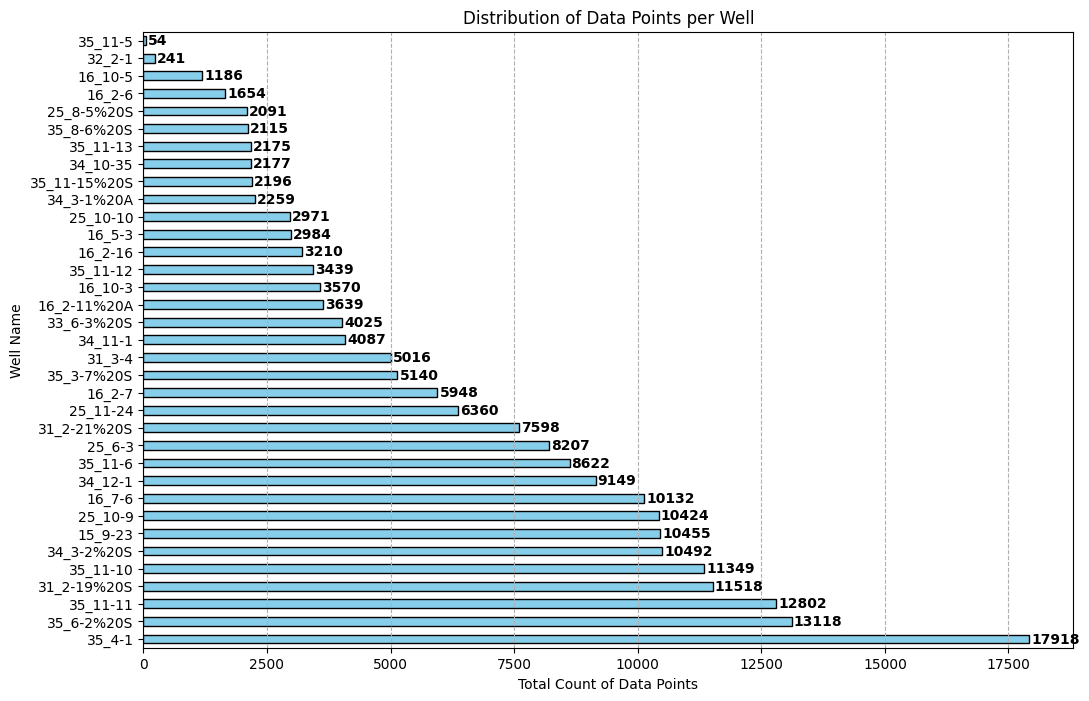

In [18]:
# Figure 1: Bar plot to visualize the total data points count in each well

# Create the bars horizontally for a cleaner visual
plt.figure(figsize=(12, 8))
bars = well_counts.plot(kind="barh", color="skyblue", edgecolor="black")

# Add the total number of points next to the bar.
for bar in bars.patches:
    plt.text(bar.get_width() + 40,  # To position the text just outside the bar
             bar.get_y() + bar.get_height() / 2,  # To position the text at the center
             f"{int(bar.get_width())}",  # Convert count to integer numbers
             ha="left", va="center", fontsize=10, fontweight="bold", color="black")

# Add labels and title
plt.ylabel("Well Name")
plt.xlabel("Total Count of Data Points")
plt.title("Distribution of Data Points per Well")
plt.grid(axis="x", linestyle="--")

# Show plot
plt.show()


### Figure 1: Distribution of Data Points per Well

the figure shows the wells and the count of data points at each well. This is done to understand the distribution in a visual way and determine the outliers and remove them.

We can see that well 35_4-1 has 17918 which is the highest outlier, this could be to due to a high sampling rate where the well collected more samples than the normal sampling rate. Similarly, we can see that well 35_11-5 has the least count of data points (54) which makes it less usefull for the analysis.

Wells (32_2-1),(16_10-5), and (16_2-6) are also considered low as they have data points less than 2000. However, to quantify the outliers statistically, the next code will perform some statistical analysis and remove the outliers based on the 25% and 27% percentiles.


In [19]:
# Calculate some basic statistics
stats_summary = {
    "Total Data Points": well_counts.sum(),
    "Mean Data Points per Well": well_counts.mean(),
    "Min Data Points in a Well": well_counts.min(),
    "Max Data Points in a Well": well_counts.max(),
    "25th Percentile": well_counts.quantile(0.25),
    "75th Percentile": well_counts.quantile(0.75),
}

# Convert to DataFrame for easy viewing
stats_df = pd.DataFrame(stats_summary.items(), columns=["Statistic", "Value"])

# Print the statistics
print(stats_df)


                   Statistic          Value
0          Total Data Points  208321.000000
1  Mean Data Points per Well    5952.028571
2  Min Data Points in a Well      54.000000
3  Max Data Points in a Well   17918.000000
4            25th Percentile    2227.500000
5            75th Percentile    9640.500000


In [20]:
# This code is to remove the extremes based on the quartiles anlysis
# Compute the 25th percentile as Q1 and 75th percentile as Q3
Q1 = well_counts.quantile(0.25)  # Lower quartile
Q3 = well_counts.quantile(0.75)  # Upper quartile

# Define the thresholds to remove wells below Q1 and above Q3
wells_to_remove = well_counts[(well_counts < Q1) | (well_counts > Q3)].index

# Remove the outlier wells from the dataset
filtered_df = cleaned_df[~cleaned_df["Well"].isin(wells_to_remove)]

# Print results
print(f"Total Wells Before Filtering: {cleaned_df['Well'].nunique()}")
print(f"Total Wells After Filtering: {filtered_df['Well'].nunique()}")
print(f"Removed {len(wells_to_remove)} extreme wells.")

Total Wells Before Filtering: 35
Total Wells After Filtering: 17
Removed 18 extreme wells.


In [21]:
# QC step of the cleaning:
# Count the total number of data points in the new filtered dataset
total_data_points = len(filtered_df)

# Print the result
print(f"Total number of data points in the new filtered dataset: {total_data_points}")


Total number of data points in the new filtered dataset: 86224


In [22]:
# QC step of the cleaning:
# Count the total number of data points per well
well_counts_2 = filtered_df["Well"].value_counts()

# Display the count results
print(well_counts_2.head(35))

Well
34_12-1        9149
35_11-6        8622
25_6-3         8207
31_2-21%20S    7598
25_11-24       6360
16_2-7         5948
35_3-7%20S     5140
31_3-4         5016
34_11-1        4087
33_6-3%20S     4025
16_2-11%20A    3639
16_10-3        3570
35_11-12       3439
16_2-16        3210
16_5-3         2984
25_10-10       2971
34_3-1%20A     2259
Name: count, dtype: int64


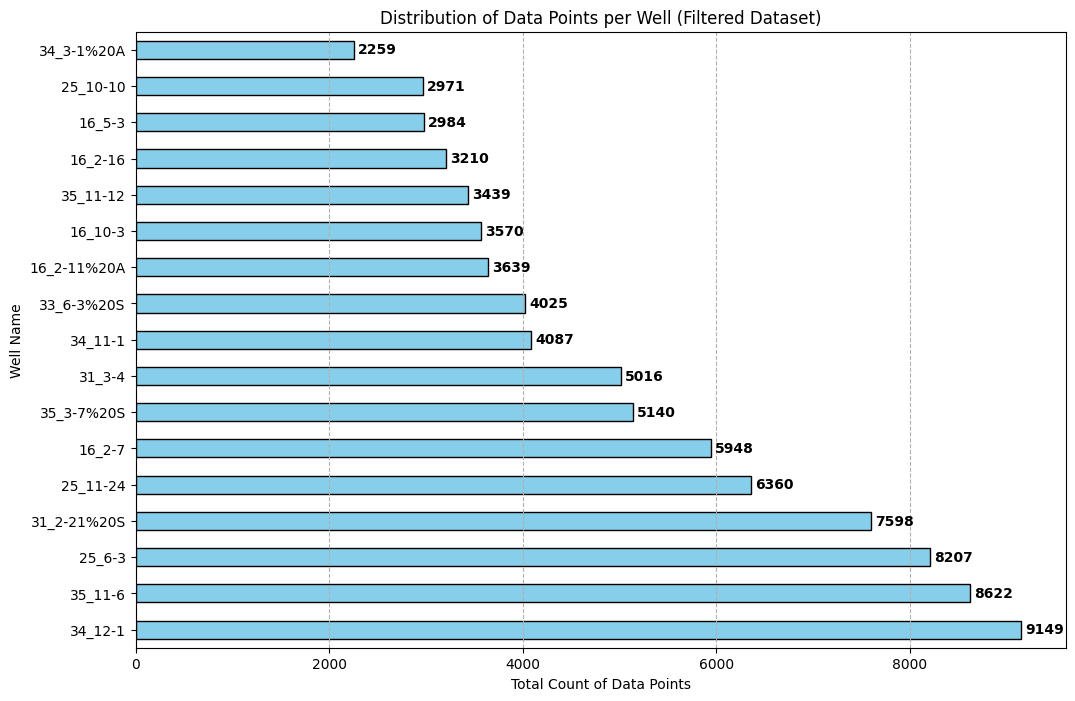

In [23]:
# Figure 2: Bar plot to visualize the total data points count in each well after filtering the outliers out of the dataset

# Create the bars horizontally for a cleaner visual
plt.figure(figsize=(12, 8))
bars = well_counts_2.plot(kind="barh", color="skyblue", edgecolor="black")

# Add the total number of points next to the bar.
for bar in bars.patches:
    plt.text(bar.get_width() + 40,  # To position the text just outside the bar
             bar.get_y() + bar.get_height() / 2,  # To position the text at the center
             f"{int(bar.get_width())}",  # Convert count to integer numbers
             ha="left", va="center", fontsize=10, fontweight="bold", color="black")

# Add labels and title
plt.ylabel("Well Name")
plt.xlabel("Total Count of Data Points")
plt.title("Distribution of Data Points per Well (Filtered Dataset)")
plt.grid(axis="x", linestyle="--")

# Show plot
plt.show()

### Figure 2: Distribution of Data Points per Well for the Filtered Dataset

The Bar plot shows the distribution of data points in each well. Compared to figure 1, the bar plot shows the wells after removing the extreme outliers by removing any count of points below the 25% quartile and any well with a a count of points above the 75%. This step was done to ensure that the dataset does not contain outliers that would highly affect the models results and cause biases in the modeling process.



Now that the data is clean from missing values, values that do not make sense geologically, and outliers, we can start visualizing the dataset in the next section.

## Section 2: Visualization

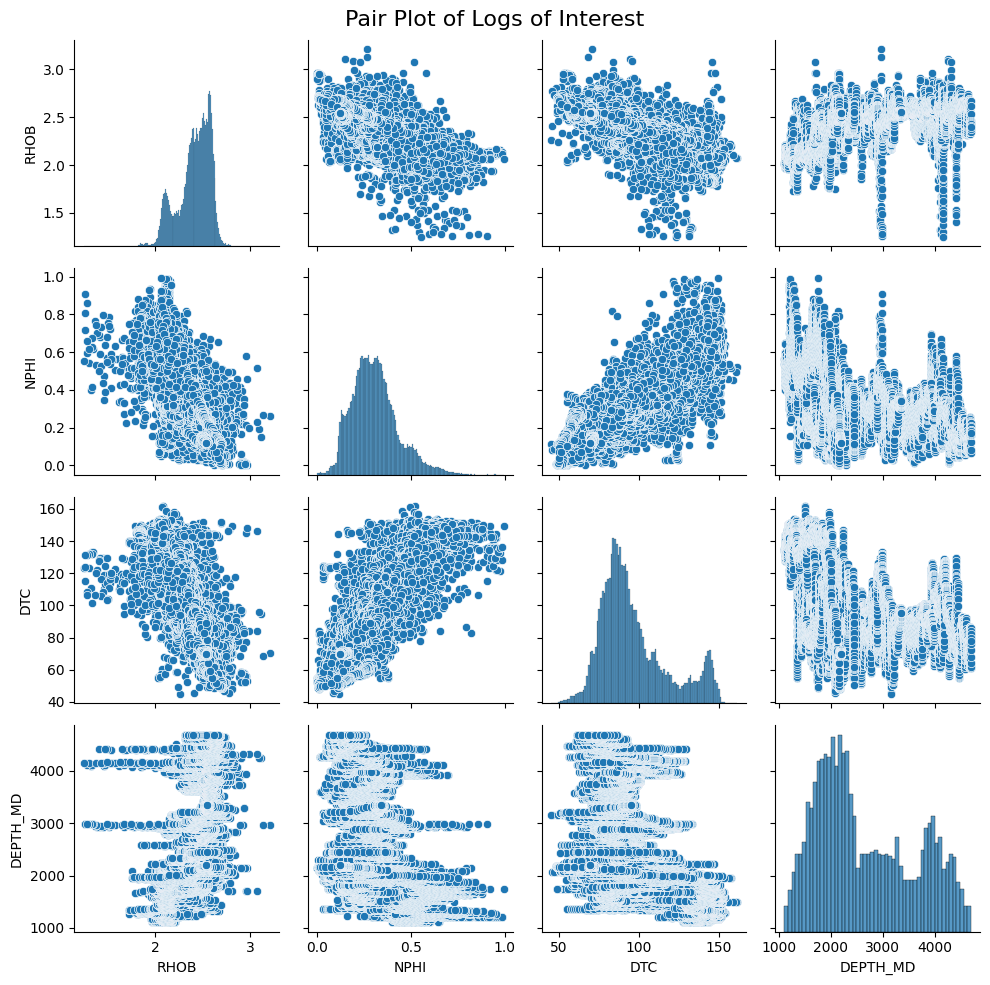

In [24]:
# Figure 3: Pair plot of the logs of interest

# Create a pair plot for the logs of interest to understand the realtionsips between them
sns.pairplot(
    filtered_df,
    vars=['RHOB', 'NPHI', 'DTC','DEPTH_MD'],  # Data columns to include
diag_kind="hist"
)

# Add title
plt.suptitle('Pair Plot of Logs of Interest', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

### Figure 3:

The Pair plot Shows the relationships between the RHOB, NPHI, measured depth (DEPTH_MD), and DTC logs.

- The RHOB vs. NPHI plot shows an expected inverse relationship, where higher porosity corresponds to lower density.

- The RHOB vs. DTC plot shows another inverse relationship, where lower DTC values (faster wave travel time ) correspond to denser rocks with higher RHOB. In contrast, higher DTC values are linked to less dense, porous formations. This relationship aligns with the behavior of compressional waves, which travel faster through compact, denser materials and slower through porous or fluid-filled formations.

- The NPHI vs. DTC plot shows a clear trend where higher porosities correlates with higher sonic travel times, indicating slower travel times in the porous formations. This also aligns with the domain knowledge and is an expected relationship.

- DEPTH_MD vs. all the logs: Looking into all the plots of depth and logs, they show clear patterns of having bands in the scatter plots which suggest distinct stratigraphic layers or geologic facies variations.

- Density histogram: Shows a skewed distribution, suggesting that most formations have moderate to high density, with fewer low-density zones.

- Neutron Porosity Histogram: It nearly shows a bimodal distibuioton which can indicate the porous and non-porous layers.

- Depth histogram: shows a 3 dominating depths where there were more samples, this could be due to these depths being of interest to the logging programs either for study porpuses or being targeted for producion.

- DTC Histogram: Shows a multimodal distribution that suggests different lithologies that are identified by the slowness


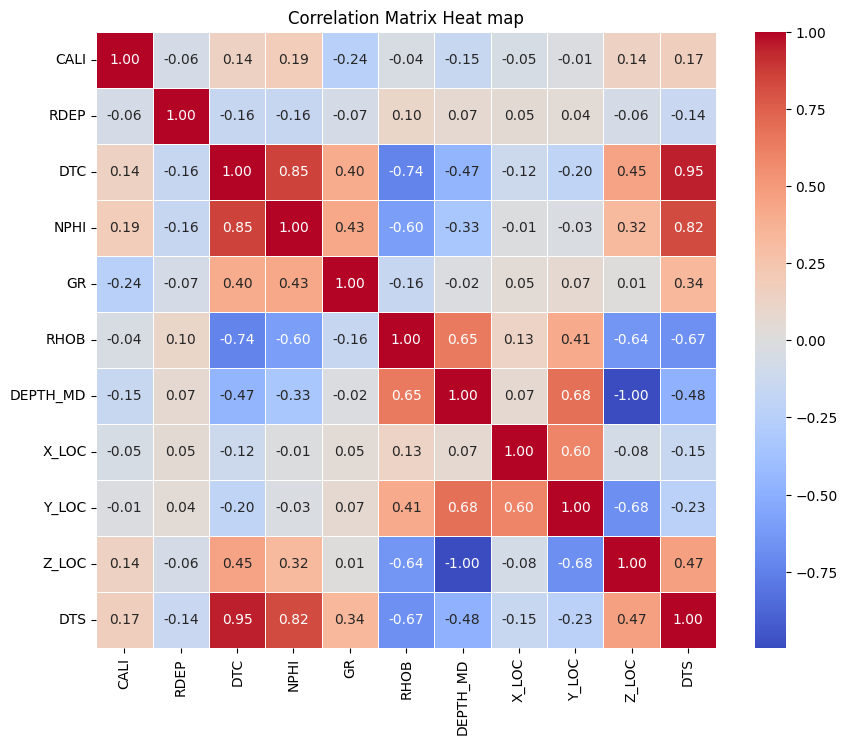

In [25]:
# Figure 4:
# This code box is to plot a correlation matrix heat map of the dataset

# Correlation matrix for numeric columns only
correlation_matrix = filtered_df.select_dtypes(include=['number']).corr() # Select only numeric columns for correlation

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Display correlation values
    cmap='coolwarm',  # Color palette
    fmt='.2f',  # Format for the numbers
    linewidths=0.5  # Line width between cells
)

# Add a title
plt.title("Correlation Matrix Heat map")

# Display the plot
plt.show()

### Figure 4: Correlation matrix heat map


The Correlation heatmap shows the relationships between the well logs, spatial coordinates, and depth.

- There are some strong negative correlations observed between DTC and RHOB (-0.74), as well as DTS and RHOB (-0.67), indicating that denser formations correspond to faster sonic wave velocities.

- The DTS and DTC have a high positive correlation (0.95) which is expected and it shows their complementary role in capturing wave propagation.

- NPHI and DTC show a strong positive correlation (0.85), suggesting that higher porosities slows down the propagation of waves.

- Depth is moderately correlated with RHOB (0.64), reflecting the trend of increasing compaction with depth.

- RHOB and NPHI has a moderate correlation of (-0.60) which represents the classic density-neutron crossover, where low-density rocks tend to have higher porosity.

The next plot is a histogram to see the distibution of each log's data points.

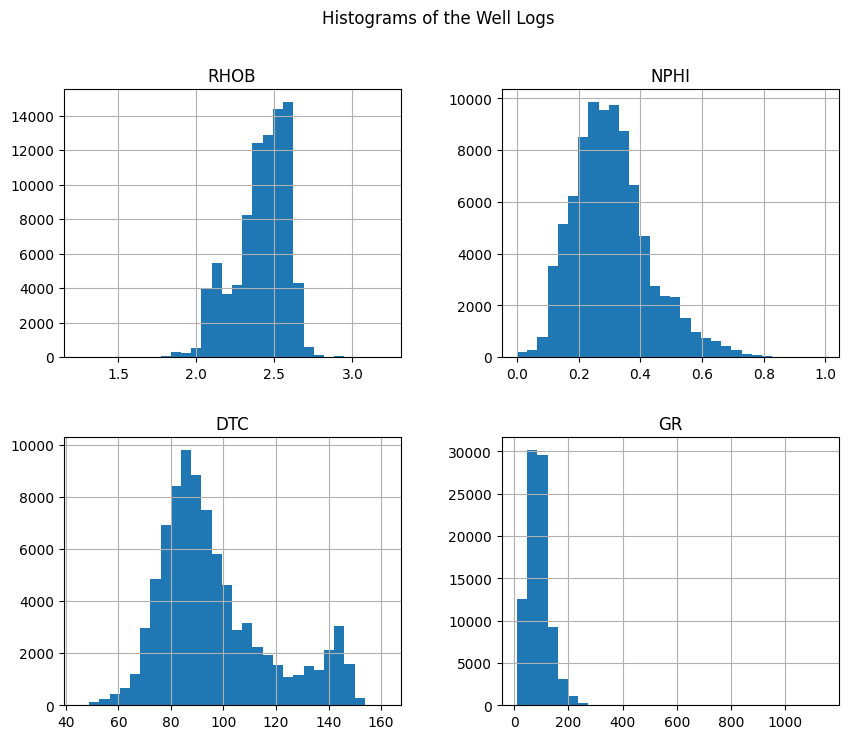

In [26]:
# Figure 5: Histograms of logs of interest

filtered_df[['RHOB', 'NPHI', 'DTC', 'GR']].hist(bins=30, figsize=(10, 8), layout=(2, 2))
plt.suptitle('Histograms of the Well Logs')
# Display the plot
plt.show()

### Figure 5: Histograms of The Well Logs

The plot shows the Histograms of well logs of interest (RHOB, NPHI, DTC, and GR) showing their distributions which can help to identify lithologies, porosity ranges, and sonic travel times within the subsurface.

- The RHOB histogram shows that most density values lie between 2.0 and 2.8 g/cm³, with a strong peak around 2.5 g/cm³. This indicates the presence of common subsurface formations such as sandstones, shales, and carbonates. The small tail toward lower densities of approximately 1.2-1.5 g/cm³ could indicate coal bed zones. This matches our domain knowledge as we know that 33% of the data is coal beds.

- The NPHI histogram shows that most porosity values range between 0.2 and 0.4, which is typical of moderate to highly porous formations like sands and porous limestones. A significant right tail extends beyond 0.6, suggesting zones of high porosity, which could correspond to unconsolidated sands.

- The DTC histogram shows that most compressional travel times lie between 60 and 140 μs/ft, with a peak around 90 μs/ft. This range suggests the presence of moderately compacted formations where wave velocities are typical of shales and sandstones. However, the right tail, extending beyond 150 μs/ft, may correspond to high-porosity zones or unconsolidated formations where wave propagation is slower due to fluid-filled pores.

- The GR histogram shows a peak around 50-150 API, suggesting that the dataset contains a significant proportion of clean formations like sands. The long tail toward higher values, exceeding 600 API, indicates the presence of shale or clay-rich formations, which are typically more radioactive due to their clay and mineral content.

The next code block is to plot the first well's logs to see how they look like

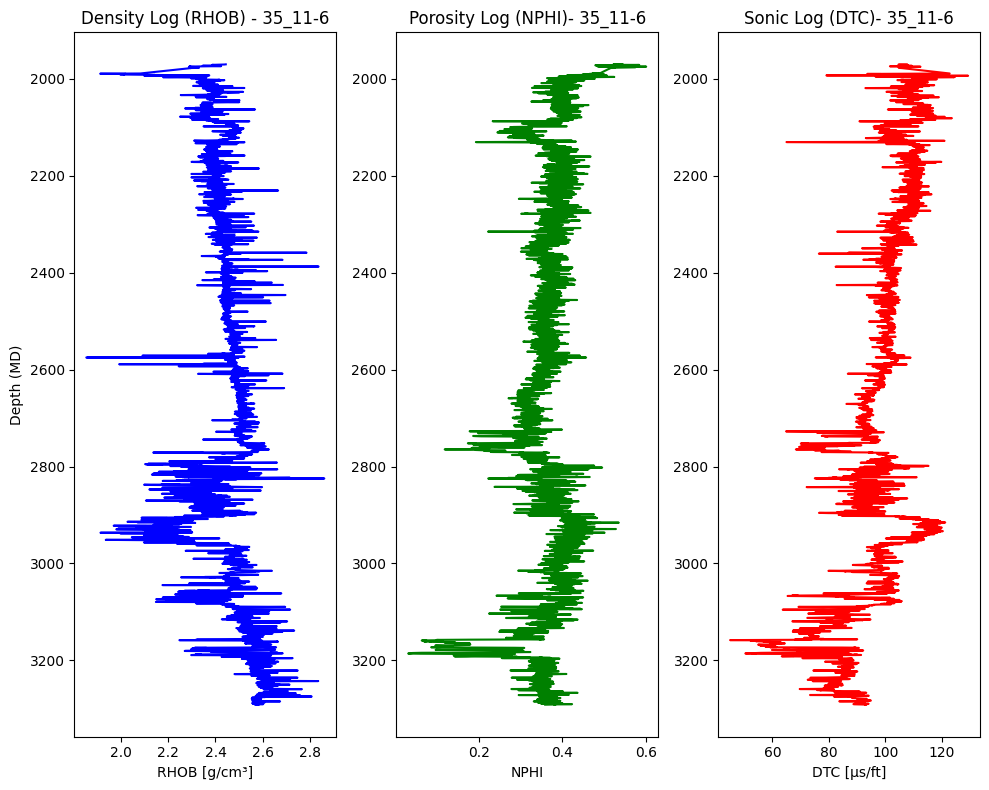

In [27]:
# Figure 6:  Well logs for the first well in the list

# Filter for the first well
well_name = filtered_df['Well'].unique()[0]  # Select the first well
well_data = filtered_df[filtered_df['Well'] == well_name]

# Plot multiple logs vs. depth for the selected well
plt.figure(figsize=(10, 8))

# Plot Density
plt.subplot(1, 3, 1)
plt.plot(well_data['RHOB'], well_data['DEPTH_MD'], color='blue')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('RHOB [g/cm³]')
plt.ylabel('Depth (MD)')
plt.title(f'Density Log (RHOB) - {well_name}')

# Plot Neutron Porosity
plt.subplot(1, 3, 2)
plt.plot(well_data['NPHI'], well_data['DEPTH_MD'], color='green')
plt.gca().invert_yaxis()
plt.xlabel('NPHI')
plt.title(f'Porosity Log (NPHI)- {well_name}')

# Plot Sonic Travel Time
plt.subplot(1, 3, 3)
plt.plot(well_data['DTC'], well_data['DEPTH_MD'], color='red')
plt.gca().invert_yaxis()
plt.xlabel('DTC [μs/ft]')
plt.title(f'Sonic Log (DTC)- {well_name}')

# Display the logs
plt.tight_layout()
plt.show()

### Figure 6: Well logs for the first well in the list

the figure plots the density, porosity, and sonic logs respetively.
We plotted a random well to visualize the data and check if there are any issues with the points after the cleaning.
the logs look good and with no issues. which confirms that the cleaning process was sufficient until this step.

---

## Section 3: Preprocessing (Scaling and Splitting)

When thinking about the best way to split the data, I wanted to make sure I avoid spatial autocorrelation in the dataset, this means that I need to account for the location of the wells in the dataset. If the test wells are too close to the training wells, the model might perform good for the wrong reasons as it would be cheating. That's why clustering by X and Y coordinates is a better method to ensure that the wells in the test set come from entirely different spatial locations, forcing the model to generalize to new areas rather than just memorizing patterns from nearby wells. At first, I also considered whether temporal correlation could be an issue, but in this case, it's not. Unlike a time-series problem where past values influence future ones, well logs represent static geological formations, not a sequential process in the time domain. Each depth reading is about rock properties at different depths, not a timeline of events. Hence, while depth matters in understanding the geology, it doesn't create a temporal dependency.

The method for the splitting will depend on performing a k-mean clustering of the wells by their location into two clusters, and then these two well clusters will be separated into the test and train models. This way, I ensure that the models train on a set and predict an entirely new location, which gives us a more realistic measure of the model's performance and ensures we aren't just getting artificially high accuracy due to wells being in close proximity to each other


The next codes will split the data to training and testing sets and scale it.

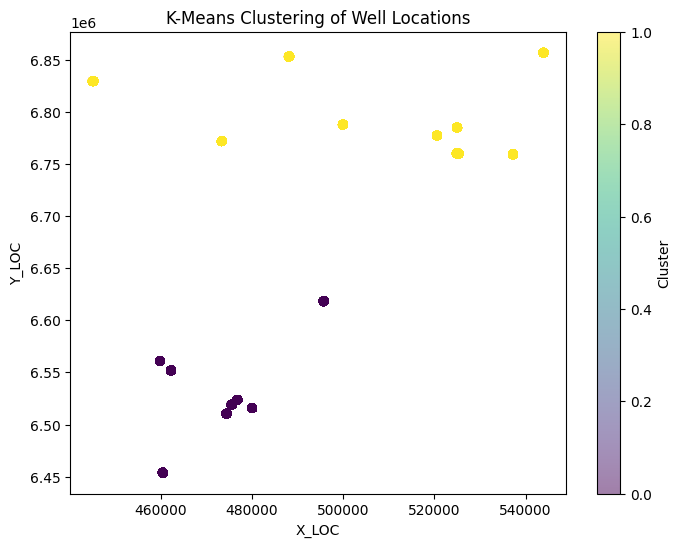

In [29]:
# This code is to perform the k-mean clustering and visualize it.
# Figure 7: K-mean clusters for the well's locations

# Use the spatial coordinates
coords = filtered_df[['X_LOC', 'Y_LOC']]

# Define number of clusters to be 2
kmeans = KMeans(n_clusters=2, random_state=42)

# Assign the clusters
filtered_df.loc[:, 'Cluster'] = kmeans.fit_predict(coords)

# Plot clusters for visualization
plt.figure(figsize=(8,6))
plt.scatter(filtered_df['X_LOC'], filtered_df['Y_LOC'], c=filtered_df['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')

# Add labels and title
plt.xlabel("X_LOC")
plt.ylabel("Y_LOC")
plt.title("K-Means Clustering of Well Locations")
plt.show()

### Figure 7: K-mean Clustering for The Wells Locations

The scatter plot shows the k-mean clustering for the dataset split into 2 distinct clusters where we can see that the split was based on locations being high and low in the y-direction.

These clusters will be used for splitting in the next code.

In [30]:
# Splitting the data based on the clusters defined

# Get unique clusters
unique_clusters = filtered_df["Cluster"].unique()

# Split clusters into training and test sets (80% train, 20% test)
train_clusters, test_clusters = train_test_split(unique_clusters, test_size=0.2, random_state=42)

# Assign wells based on the selected clusters
train_df = filtered_df[filtered_df["Cluster"].isin(train_clusters)]
test_df = filtered_df[filtered_df["Cluster"].isin(test_clusters)]

# Remove cluster column (no longer needed)
train_df = train_df.drop(columns=["Cluster"])
test_df = test_df.drop(columns=["Cluster"])

# Print the clusters for QC and the total number of data points in each set
print(f"Training Clusters: {len(train_clusters)}")
print(f"Test Clusters: {len(test_clusters)}")
print(f"Training set size: {len(train_df)} samples")
print(f"Test set size: {len(test_df)} samples")


Training Clusters: 1
Test Clusters: 1
Training set size: 49335 samples
Test set size: 36889 samples


In [31]:
# This code is to scale the data before peforming the models


# Define the features to be scaled
features_to_scale = ["DTC", "GR", "NPHI"]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test sets
X_train_scaled = scaler.fit_transform(train_df[features_to_scale])
X_test_scaled = scaler.transform(test_df[features_to_scale])

# Check the scaled training data
X_train_scaled[:10]



array([[ 1.22353092, -1.31188223,  2.52286599],
       [ 1.15386231, -1.33867482,  2.58576212],
       [ 1.12654748, -1.34763611,  2.75551371],
       [ 1.05605604, -1.35349323,  2.7107354 ],
       [ 1.00665122, -1.32087713,  2.5995768 ],
       [ 1.04335086, -1.29457666,  2.49008663],
       [ 1.10192081, -1.29472703,  2.55145254],
       [ 1.16049803, -1.32405704,  2.94417158],
       [ 1.21727084, -1.30879481,  3.17696011],
       [ 1.25163225, -1.30579579,  3.09155089]])

## Section 4: Linear Regression Model




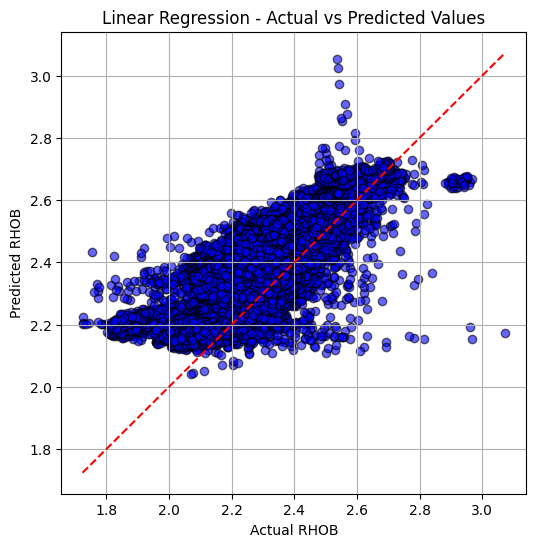

Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0164
Mean Absolute Error (MAE): 0.1002
Mean Absolute Percentage Error (MAPE): 0.0446


In [32]:
# Model 1: Linear Regression
# Figure 8: Linear Regression Model (Predicted vs Actual RHOB Values)

# Define the target variable (RHOB)
y_train = train_df["RHOB"].values  # Convert to NumPy array for compatibility
y_test = test_df["RHOB"].values

# Train a Linear Regression model
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_reg = reg_model.predict(X_test_scaled)

# Evaluate the model with different metrics:

# Mean Squared Error:
# MSE: Measures how far the predicted values are from the actual values. Smaller is better.
mse_reg = mean_squared_error(y_test, y_pred_reg)

# Mean Absolute Error
# MAE: Calculates how far on average the predicted values deviate from the actual values, without considering direction of the values.
mae_reg = mean_absolute_error(y_test, y_pred_reg)

# Mean Absolute Percentage Error
# MAPE: Represents the average percentage difference between the actual and predicted values, relative to the actual values.
mape_reg = mean_absolute_percentage_error(y_test, y_pred_reg)

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    "Mean Squared Error (MSE)": mse_reg,
    "Mean Absolute Error (MAE)": mae_reg,
    "Mean Absolute Percentage Error (MAPE)": mape_reg
}

# Scatter plot: Actual vs. Predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_reg, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")  # Perfect prediction line
plt.xlabel("Actual RHOB")
plt.ylabel("Predicted RHOB")
plt.title("Linear Regression - Actual vs Predicted Values")
plt.grid(True)
plt.show()

# Print evaluation results
print("Model Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric}: {value:.4f}")  # Display values with 4 decimal places


### Figure 8: Linear Regression Model (Predicted vs Actual RHOB Values)

The scatter plot compares the actual vs. predicted RHOB (Density) values generated by the Linear Regression model. The red dashed line represents perfect one-to-one predictions, where all points would lie if the model were entirely correct. The blue scatter points show the actual predictions made by the model. The best case for the model's performance is when the points are plotted closely along the red line. From the plot, we observe that most predictions follow the general trend of the actual RHOB values, suggesting a strong correlation between the model's predictions and the actual values. However, there is a noticeable spread around the line, indicating prediction errors. The model appears to underestimate lower RHOB values and overestimate higher RHOB values, suggesting that it struggles with extreme values.


Evaluation Metrics:

- The MSE represents the average squared difference between the actual RHOB values and the predicted ones. The resulting MSE of 0.0164 is low, which means good accuracy in the predictions and that they are close to the actual values.

- The MAE value of  0.1002 represents the average absolute difference between actual and predicted RHOB values. In practical terms, the model's predictions are off by about 0.1 g/cm³ on average, which gives a more interpretable measure of error than MSE.

- The MAPE shows the error relative to the actual values, meaning that, on average, the model's predictions deviate by 4.46% from the actual RHOB values.

Overall, the model shows a decent predictions ability, where it captured the general trend of the RHOB values with relatively low errors. However, the spread in predictions, especially for lower and higher RHOB values, indicates that a simple linear regression model may not be sufficient to fully capture the underlying geological relationships.This limitation could be due to the insufficient number of data points for the model to train on these extremes.




These results are not too bad, however, not the best. As the linear regression assumes linear relationship which might not be the case in real-world wells data. The result we got is moderately acceptable. However, the next code will look into the KNN modelling method to see if it can account for the non-linearity.

---

## Section 5: KNN


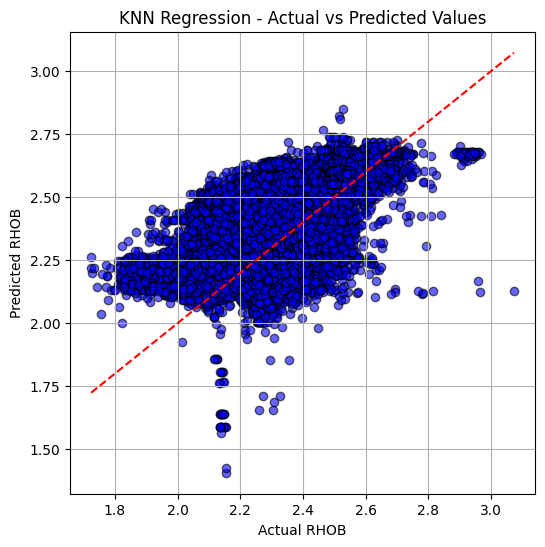

KNN Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0207
Mean Absolute Error (MAE): 0.1119
Mean Absolute Percentage Error (MAPE): 0.0494


In [33]:
# Model 2: KNN Regression
# Figure 9: KNN Regression Model (Predicted vs Actual RHOB Values)

# Train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  # Using k=5 as a starting point
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model with the same metrics used for the linear regression for a comparison later on
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)

# Store evaluation metrics in a dictionary
evaluation_metrics_knn = {
    "Mean Squared Error (MSE)": mse_knn,
    "Mean Absolute Error (MAE)": mae_knn,
    "Mean Absolute Percentage Error (MAPE)": mape_knn
}

# Scatter plot: Actual vs. Predicted values for KNN
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")  # Perfect prediction line
plt.xlabel("Actual RHOB")
plt.ylabel("Predicted RHOB")
plt.title("KNN Regression - Actual vs Predicted Values")
plt.grid(True)
plt.show()

# Print evaluation results
print("KNN Model Evaluation Metrics:")
for metric, value in evaluation_metrics_knn.items():
    print(f"{metric}: {value:.4f}")  # Display values with 4 decimal places

### Figure 9: KNN Regression Model (Predicted vs Actual RHOB Values)

The scatter plot shows the actual vs. predicted RHOB values using the K-Nearest Neighbors (KNN) regression model. The red dashed line represents perfect predictions, where all points would lie if the model had zero error. The blue scatter points represent the prediction values. We can see that most of the predictions aligns with the general trend of the true RHOB values, which is a similar trend to the linear regression model. However, there is a noticeable spread, particularly in lower RHOB values, where some predictions deviate significantly from the actual trend. Additionally, several points fall below the red dashed line, suggesting that the KNN model underestimated the RHOB values more frequently than the linear regression model.

Evaluation Metrics:

The KNN model was evaluated using the same three performance metrics used for the linear regression to be consistent throughout the notebook analysis:
- The MSE value is 0.0207, which is slightly higher MSE compared to the linear regression model (0.0164) suggests that KNN introduces more variance in predictions, likely due to localized errors from the nearest-neighbor approach.

- The MAE shows that on average the model's predictions deviate by 0.1119 g/cm³ from the actual RHOB values. This is higher than the MAE from linear regression (0.1002), suggesting that KNN produces slightly larger absolute errors.

- The MAPE is 4.94% which indicates that the model's predictions are on average 4.94% off from the actual RHOB values. Compared to linear regression (4.46%), KNN performs slightly worse in relative error, implying less reliable predictions.


The KNN regression model performs slightly worse than the linear regression model, as indicated by higher MSE, MAE, and MAPE values. While KNN is capable of capturing non-linear relationships, it may not be the best choice for this dataset due to its sensitivity to noise and localized errors. Additionally, KNN depend on the k hyperparameter, adjusting this hyperparameter might improve the results. However, currently the linear regression seems to perfrom better.

The next code will perform a third modeling type which is the Decision Tree Regressor to see and compare the performances.



---

## Section 6: Decision Tree Regressor


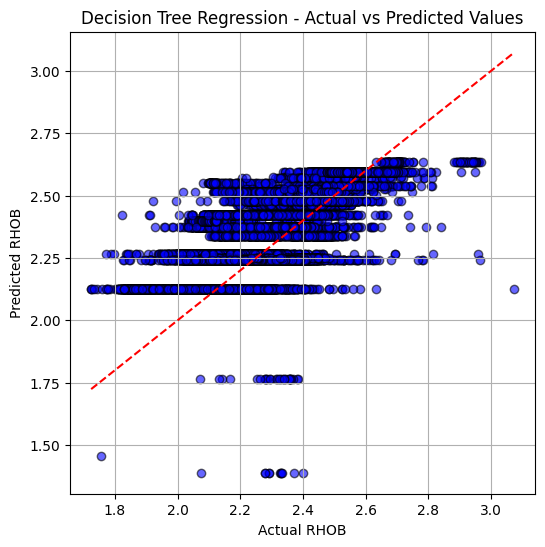

Decision Tree Model Evaluation Metrics:
Mean Squared Error (MSE): 0.0174
Mean Absolute Error (MAE): 0.1028
Mean Absolute Percentage Error (MAPE): 0.0456


In [34]:
# Model 3: Decision Tree model
# Figure 10: Decision Tree model (Predicted vs Actual RHOB Values)

# Train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)  # Limit depth to prevent overfitting
dt_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the model with the three metrics
dt_mse = mean_squared_error(y_test, y_pred_dt)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_mape = mean_absolute_percentage_error(y_test, y_pred_dt)

# Store evaluation metrics in a dictionary
evaluation_metrics_dt = {
    "Mean Squared Error (MSE)": dt_mse,
    "Mean Absolute Error (MAE)": dt_mae,
    "Mean Absolute Percentage Error (MAPE)": dt_mape
}

# Scatter plot: Actual vs. Predicted values for Decision Tree Regression
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")  # Perfect prediction line
plt.xlabel("Actual RHOB")
plt.ylabel("Predicted RHOB")
plt.title("Decision Tree Regression - Actual vs Predicted Values")
plt.grid(True)
plt.show()

# Print evaluation results
print("Decision Tree Model Evaluation Metrics:")
for metric, value in evaluation_metrics_dt.items():
    print(f"{metric}: {value:.4f}")  # Display values with 4 decimal places

### Figure 10: Decision Tree Model (Predicted vs Actual RHOB Values)

The scatter plot shows the actual vs. predicted RHOB (Density) values using the Decision Tree Regression model. The red dashed line represents perfect predictions, where every point would lie if the model had no error. The blue scatter points represent the actual predictions from the model. We can see that many of the predicted values are clustered into horizontal bands, this happens because Decision Trees make decisions based on fixed threshold splits rather than continuous calculations leading to these flat regions in the plot. The model shows some alignment with the red dashed line, but there is a clear spread and grouping of predictions, suggesting that the tree might be too simplified and is not fully capturing the complexity of the data. The model also underestimates lower RHOB values and overestimates higher ones, indicating it may struggle with generalization.

Evaluation Metrics:

The model's performance is evaluated using the same three metrics:
- The MSE of (0.0174) is slightly higher than the Linear Regression (0.0164) but lower than KNN (0.0207). This suggests that while Decision Trees can model non-linear relationships, they may not be as effective in reducing variance as a well-fitted linear model.

- The MAE indicates that the model's predictions deviate by about 0.1028 g/cm³ from actual RHOB values.

- The MAPE shows that the model's predictions are on average 4.56% off from the actual RHOB values.

The Decision Tree Regression model performs moderately well, with results slightly worse than Linear Regression but better than KNN in terms of MAPE and MAE. However, the step-like prediction pattern suggests that the model may not be capturing finer details in the data, potentially due to the maximum depth limitation (max_depth=5) restricting its complexity.

## Section 7 : Comparison and Conclusion of The Three Models


In [35]:
# Comparison between the three models by their metrics

# Create a DataFrame to display the saved evaluation metrics for the three models
metrics_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "KNN Regression", "Decision Tree Regression"],
    "MSE": [mse_reg, mse_knn, dt_mse],
    "MAE": [mae_reg, mae_knn, dt_mae],
    "MAPE": [mape_reg, mape_knn, dt_mape]
})

# Print the table
metrics_comparison


,Model,MSE,MAE,MAPE
0,Linear Regression,0.016382,0.100156,0.044567
1,KNN Regression,0.020709,0.111866,0.049418
2,Decision Tree Regression,0.017351,0.102781,0.045642


### Comparison of The Three Regression Models
The table summarizes the performance of Linear Regression, KNN Regression, and Decision Tree Regression using the three evaluation metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).

Linear Regression performed the best overall, achieving the lowest MSE (0.0164), MAE (0.1002), and MAPE (4.46%). This suggests that a simple linear model is effective in predicting RHOB values, likely because the relationships between the features and RHOB may have a strong linear component.

KNN Regression had the worst performance, with the highest MSE (0.0207), MAE (0.1119), and MAPE (4.94%). This suggests that KNN struggled with capturing trends in the data, possibly due to its sensitivity to noise and the way it averages nearby points.

Decision Tree Regression performed slightly better than KNN but did not surpass Linear Regression. It had MSE (0.0174), MAE (0.1029), and MAPE (4.56%), indicating that while it captured some non-linearity, it produced more step-like predictions, which may have limited its accuracy.

### Conclusion

The Linear Regression model had performed the best, giving the lowest error values which indicates that the relationship between RHOB and the input features (GR, NPHI, and DTC) is largely linear. However, while it provides stable and reliable predictions, it may not fully capture more complex variations in the data.

KNN Regression had the highest errors, showing that it struggled to make accurate predictions. Since KNN relies on averaging nearby data points, it may not be the best approach for well log data, where trends are not always locally consistent.

Decision Tree Regression performed slightly better than KNN, capturing some non-linear patterns. However, its step-like predictions indicate that it does not generalize well across different RHOB values. This suggests that a single decision tree may not be the best option on its own.

## Section 8: Assignment Questions


**Which method did you like the most?**

I liked Linear Regression the most because it provided the best accuracy with the lowest errors while remaining simple and interpretable. It performed better than KNN and Decision Tree Regression, suggesting that RHOB has a strong linear relationship with the input features. While it may not capture all complexities, its balance of accuracy and simplicity makes it the most reliable choice for this assignment.


**Which method did you like the least?**

I liked the Decision Tree Regression the least because, while it performed slightly better than KNN, its step-like predictions limited its accuracy. The model struggled to generalize across different RHOB values. This could be due to its reliance on threshold-based splits. Compared to Linear Regression, it lacked smooth predictions and had higher errors, making it less reliable for the log prediction.

**How did you score these supervised models?**

I scored these supervised models using three evaluation metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). MSE measures the average squared difference between actual and predicted values. MAE calculates the average absolute difference, providing a more interpretable measure of the error. MAPE presents the errors as a percentage, allowing for comparison across different scales. Lower values in all three metrics indicate better model performance.

**Did the output align with your geologic understanding?**

Yes, the output partially aligned with my geologic understanding. Linear Regression performed the best, which suggests that RHOB has a strong linear relationship with the input features (DTC, GR, NPHI), which is consistent with general petrophysical trends. However, I expected Decision Tree Regression to perform better since subsurface properties often exhibit non-linear variations. The step-like predictions from the Decision Tree model indicate that it may not have captured the full complexity of geological formations.

**What did you want to learn more about?**

After the results of the Decision Tree Regression, I want to learn more about how non-linear models, such as Random Forest and Gradient Boosting, could improve predictions by capturing more complex geological relationships. While Linear Regression performed well, subsurface properties often exhibit non-linear variations, which tree-based models or neural networks might handle better. This might be a step for my final submission

**Did you pre-process your data?**

Yes, I pre-processed the data to ensure accurate and unbiased model performance. First, I split the dataset using well clustering with K-Means to preventing spatial autocorrelation and data leakage. To ensure consistency across models, I applied feature scaling with StandardScaler to normalize DTC, GR, and NPHI, since models like KNN and Linear Regression are sensitive to scale. Additionally, I cleaned the data by removing outliers using the quantiles by removing any value less that the 25% quantile and more than the 75% quantile. this helped in reducing the impact of extreme values on the predictions. Finally, I split hte training and test sets so that the models were tested on unseen wells which ensures better generalization to new data.

**Do all models require pre-processing?**

Yes, but not all models require the same level of pre-processing. Linear Regression and KNN Regression need feature scaling since they rely on numerical distances, while Decision Tree Regression does not because it splits data based on thresholds. However, all models benefit from data cleaning, outlier removal, and structured splitting to prevent data leakage and bias.